In [1]:
import numpy as np

In [2]:
# 拡張ローゼンブロック（Rosenbrock）関数の実装である。
# 典型的な最適化ベンチマークで、細長い谷（狭い等高線）を持つため、
# 勾配法ではジグザグ収束、準ニュートン/ニュートンでは高速収束の挙動が観察できる。
# 次元 n の変数 x = (x_0, x_1, ..., x_{n-1}) に対し、
#   f(x) = Σ_{i=0}^{n-2} [ 100 (x_{i+1} - x_i^2)^2 + (x_i - 1)^2 ]
# を定義する（最小値は x* = (1,1,...,1) かつ f(x*) = 0 である）。


def func_Ex_rosen(x: np.ndarray) -> float:
    """
    拡張ローゼンブロック関数 f(x) の目的関数値を返す関数である。

    定義：
        f(x) = Σ_{i=0}^{n-2} [ 100 (x_{i+1} - x_i^2)^2 + (x_i - 1)^2 ]

    計算量：
        O(n)。隣接成分のみを参照するため線形である。

    Parameters
    ----------
    x : np.ndarray (n,)
        評価点ベクトル

    Returns
    -------
    float
        目的関数値 f(x)
    """
    # ベクトル化して i=0..n-2 の項をまとめて計算するである。
    # x[:-1] が (x_0, ..., x_{n-2}), x[1:] が (x_1, ..., x_{n-1}) に対応する。
    return np.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (x[:-1] - 1.0) ** 2)


def grad_Ex_rosen(x: np.ndarray) -> np.ndarray:
    """
    拡張ローゼンブロック関数の勾配 ∇f(x) を返す関数である。

    成分表示（0-based）：
        g_0   = ∂f/∂x_0   = -400 x_0 (x_1 - x_0^2) + 2 (x_0 - 1)
        g_i   = ∂f/∂x_i   = 200 (x_i - x_{i-1}^2) - 400 x_i (x_{i+1} - x_i^2) + 2 (x_i - 1),  i=1..n-2
        g_{n-1}=∂f/∂x_{n-1}= 200 (x_{n-1} - x_{n-2}^2)

    構造：
        各成分は高々隣接（i-1, i, i+1）に依存するため、計算は O(n) である。

    Parameters
    ----------
    x : np.ndarray (n,)
        評価点ベクトル

    Returns
    -------
    np.ndarray (n,)
        勾配ベクトル ∇f(x)
    """
    n = len(x)
    grad = np.zeros(n)

    # 端点 i=0 の特別扱いである（x_{-1}, x_{n} は存在しないため）。
    grad[0] = -400.0 * x[0] * (x[1] - x[0] ** 2) + 2.0 * (x[0] - 1.0)

    # 中間成分 i=1..n-2：左隣の「(x_i - x_{i-1}^2)」と右隣の「(x_{i+1} - x_i^2)」の双方に現れる。
    for i in range(1, n - 1):
        grad[i] = (
            200.0 * (x[i] - x[i - 1] ** 2)  # 左隣の項の x_i への寄与
            - 400.0 * x[i] * (x[i + 1] - x[i] ** 2)  # 右隣の項の x_i への寄与
            + 2.0 * (x[i] - 1.0)  # 正則化項 (x_i - 1)^2 の勾配
        )

    # 端点 i=n-1：右隣が無いため、左隣の項のみが寄与する。
    grad[n - 1] = 200.0 * (x[n - 1] - x[n - 2] ** 2)

    return grad


def hess_Ex_rosen(x: np.ndarray) -> np.ndarray:
    """
    拡張ローゼンブロック関数のヘッセ行列 ∇²f(x) を返す関数である。

    構造：
        三重対角（tridiagonal）に近い疎構造を持つ（主対角と両隣のみ非零）。
        具体的には、
          H[0,0]   = 1200 x_0^2 - 400 x_1 + 2
          H[i,i]   = 1200 x_i^2 - 400 x_{i+1} + 202,   i=1..n-2
          H[n-1,n-1]= 200
          H[i,i+1] = H[i+1,i] = -400 x_i,              i=0..n-2
        それ以外は 0 である。

    数値計算上の注意：
        ・ニュートン法では H の正定性が保証されない場合があり、ステップが不安定になり得る。
          ラインサーチや信頼領域法、正則化（H + λI）との併用が有効である。
        ・本実装は密行列を返すが、大規模 n では三重対角疎行列として扱うと計算・メモリ効率が良い。

    Parameters
    ----------
    x : np.ndarray (n,)
        評価点ベクトル

    Returns
    -------
    np.ndarray (n, n)
        ヘッセ行列 ∇²f(x)
    """
    n = len(x)
    H = np.zeros((n, n))

    # 主対角：i=0 の特別扱い
    #  d^2/dx0^2 [100(x1 - x0^2)^2 + (x0 - 1)^2]
    #    = 1200 x0^2 - 400 x1 + 2
    H[0, 0] = 1200.0 * x[0] ** 2 - 400.0 * x[1] + 2.0

    # 主対角：i=1..n-2
    #  右隣の項 100(x_{i+1} - x_i^2)^2 の x_i についての二階微分が 1200 x_i^2 - 400 x_{i+1} を与える。
    #  左隣の項 100(x_i - x_{i-1}^2)^2 の x_i についての二階微分が 200 を与える。
    #  加えて (x_i - 1)^2 の二階微分が 2 を与える。計 1200 x_i^2 - 400 x_{i+1} + 202。
    for i in range(1, n - 1):
        H[i, i] = 1200.0 * x[i] ** 2 - 400.0 * x[i + 1] + 202.0

    # 主対角：i=n-1
    #  右隣の項が存在しないため、左隣の項の二階微分 200 のみである。
    H[n - 1, n - 1] = 200.0

    # 非対角（隣接のみ）：H[i, i+1] = H[i+1, i] = -400 x_i
    #  これは 100(x_{i+1} - x_i^2)^2 の混合二階微分から生じる。
    for i in range(n - 1):
        H[i, i + 1] = -400.0 * x[i]
        H[i + 1, i] = -400.0 * x[i]

    return H

In [4]:
from code3_1v2 import *  # 最急降下法（点列のログを残すバージョン）のコードを読み込み
from code3_2v2 import *  # 非線形共役勾配法（点列のログを残すバージョン）のコードを読み込み
from code4_1v2 import *  # ニュートン法（点列のログを残すバージョン）のコードを読み込み
from code4_3v2 import *  # 準ニュートン法（点列のログを残すバージョン）のコードを読み込み

SD, iter: 5000 f(x): 0.0006752204540018139
CG(HS), iter: 80 f(x): 2.8407423761241142e-21
Newton, iter: 4 f(x): 1.2942249226282225e-30
QNewton, iter: 16 f(x): 1.1588187848138308e-24


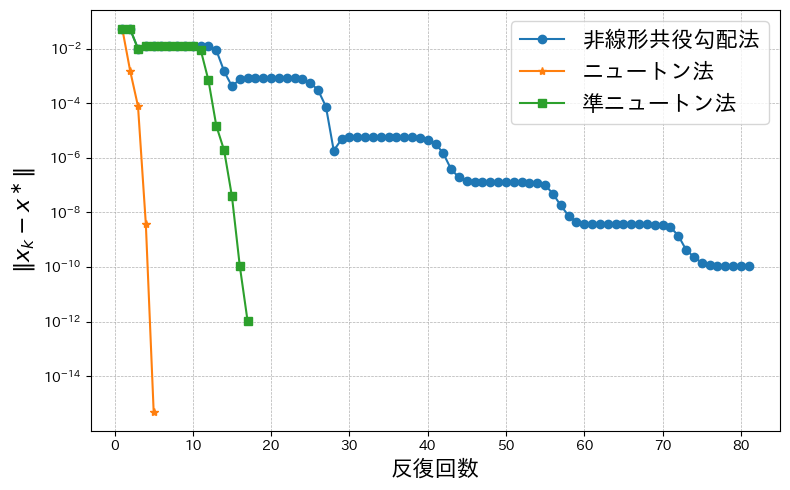

In [5]:
# 収束曲線（誤差ノルム）の可視化コードである。
# 目的：拡張Rosenbrock関数に対し、非線形最適化の各手法（CG, Newton, 準Newton）の
#       収束挙動（‖x_k - x*‖）を比較するである。
# 前提：
#   - func_Ex_rosen, grad_Ex_rosen, hess_Ex_rosen は既に定義済みである。
#   - SteepestDescent（点列返却版）, CG_HS（点列返却版）, Newton（点列返却版）,
#     QuasiNewton（点列返却版）が利用可能である。
#   - 各手法は「点列（各反復の x_k）を縦ベクトルで積んだ 2 次元配列」を返す前提である。
#     もしベクトルを返す実装であれば、誤差系列を計算する箇所を適宜修正する必要があるである。

%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語ラベルをプロットに用いるためである
import numpy as np

# -----------------------------
# 実験設定
# -----------------------------
dim = 10                   # 次元数 n=10（高次元でも構造は疎であり計算は容易である）
x_0 = np.zeros(dim)        # 初期点：ゼロベクトル（谷筋に入る前の難しい初期化である）
x_ast = np.ones(dim)       # 最適解 x* = (1,1,...,1)

# -----------------------------
# ウォームスタートのための前処理
# -----------------------------
# SteepestDescent（最急降下法）である程度谷筋へ寄せ、他手法の初期点を改善するである。
# こうすることで Newton/準Newton/CG が本来の収束特性（局所の高速収束）を示しやすくなる。
sequenceSD = SteepestDescent(func_Ex_rosen, grad_Ex_rosen, x_0, max_iter=5000)
x_00 = sequenceSD[-1, :]   # SD の最終点を他手法の初期点とするである

# -----------------------------
# 各手法の適用（点列の取得）
# -----------------------------
# 非線形共役勾配法（Hestenes–Stiefel）である。
sequenceCG = CG_HS(func_Ex_rosen, grad_Ex_rosen, x_00, eps=1.0e-10)

# ニュートン法（ヘッセ利用）。ログ版（点列返却）を用いるである。
sequenceN = Newton(func_Ex_rosen, grad_Ex_rosen, hess_Ex_rosen, x_00, eps=1.0e-10)

# 準ニュートン法（BFGS の H 公式ベースを想定）。ログ版（点列返却）を用いるである。
# もし関数が最終点のみ返す実装であれば、誤差系列は単一点となるため、
# 学術的比較の観点からは「点列版」を用いることを推奨するである。
sequenceQN = QuasiNewton(func_Ex_rosen, grad_Ex_rosen, x_00, eps=1.0e-10)

# -----------------------------
# 誤差系列の算出
# -----------------------------
# 各反復 k における誤差ノルム ‖x_k - x*‖_2 を計算するである。
# shape: (T, n) の配列に対し axis=1 で2ノルムを取る。
err_CG = np.linalg.norm(sequenceCG - x_ast, axis=1)
err_Newton = np.linalg.norm(sequenceN - x_ast, axis=1)
err_QuasiNewton = np.linalg.norm(sequenceQN - x_ast, axis=1)

# -----------------------------
# 可視化（縦軸対数スケール）
# -----------------------------
# 収束速度の差異（直線の傾き）を視認しやすくするため semilogy を用いるである。
plt.figure(figsize=(8, 5))

ax_iter = np.arange(1, len(err_CG) + 1)  # 反復回数の配列（1始まり）
plt.semilogy(ax_iter, err_CG, marker='o', linestyle='-', label='非線形共役勾配法')

ax_iter = np.arange(1, len(err_Newton) + 1)
plt.semilogy(ax_iter, err_Newton, marker='*', linestyle='-', label='ニュートン法')

ax_iter = np.arange(1, len(err_QuasiNewton) + 1)
plt.semilogy(ax_iter, err_QuasiNewton, marker='s', linestyle='-', label='準ニュートン法')

# 軸ラベル・凡例・グリッド設定
plt.xlabel('反復回数', fontsize=16)                 # 横軸：k
plt.ylabel(r'$\|x_k - x^\ast\|$', fontsize=16)     # 縦軸：誤差ノルム
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=16)

# 表示
plt.tight_layout()
plt.show()